# Profile KMeans

In [3]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Running on the Remote

On MPSD:
```
tmux new -s jlab
source programs/isdfBenchmarks/.venv/bin/activate
jupyter lab --no-browser --ip=0.0.0.0 --port 8888
```

Detach with `Ctrl-b d`
Reattach with: `tmux attach -t jlab`
Paste the Jupyter URL into `Settings > Jupyter > Jupyter Servers > Configured servers`
and save the token proceeding the URL, ask Pycharm will ask for it


### Generate Inputs

kmeans with L2 norm

* Call `jobs/kmeans_profiling.py` locally, then SCP the inputs across
*   Submitted batch job 283930 for anthracene, as a test
*   Submit the rest in `/home/bucchera/exchange_calcs/kmeans_l2`



In [7]:
""" Reference Data using the Algorithm in Main
"""
from pathlib import Path

from isdfbenchmarks.parser.profiling import parse_time

# TODO(Alex) Re-run these such that a consistent grid, N ISDF and KMeans Repetition are used
# Parse ISDF profiling times 
results_root = Path("/home/bucchera/exchange_calcs/mpi_isdf")
directories =  ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"]

isdf_results = {}
for dir in directories:
    cumulative, self = parse_time(results_root / dir / "profiling/time.000000")
    isdf_results[dir] = {'cumulative': cumulative, 'self':self}


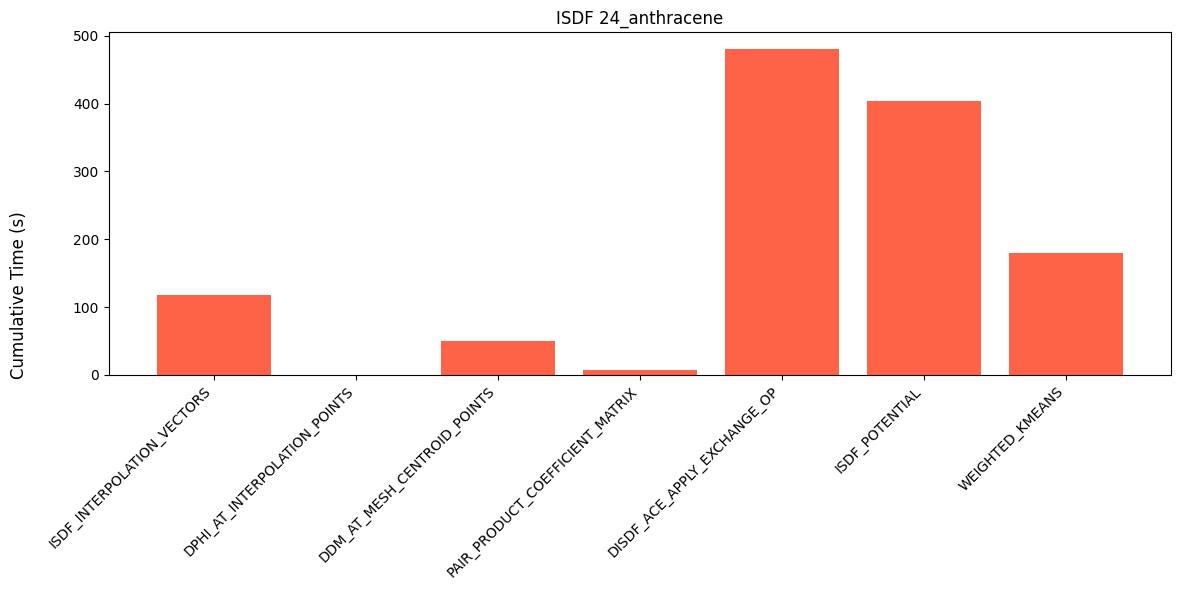

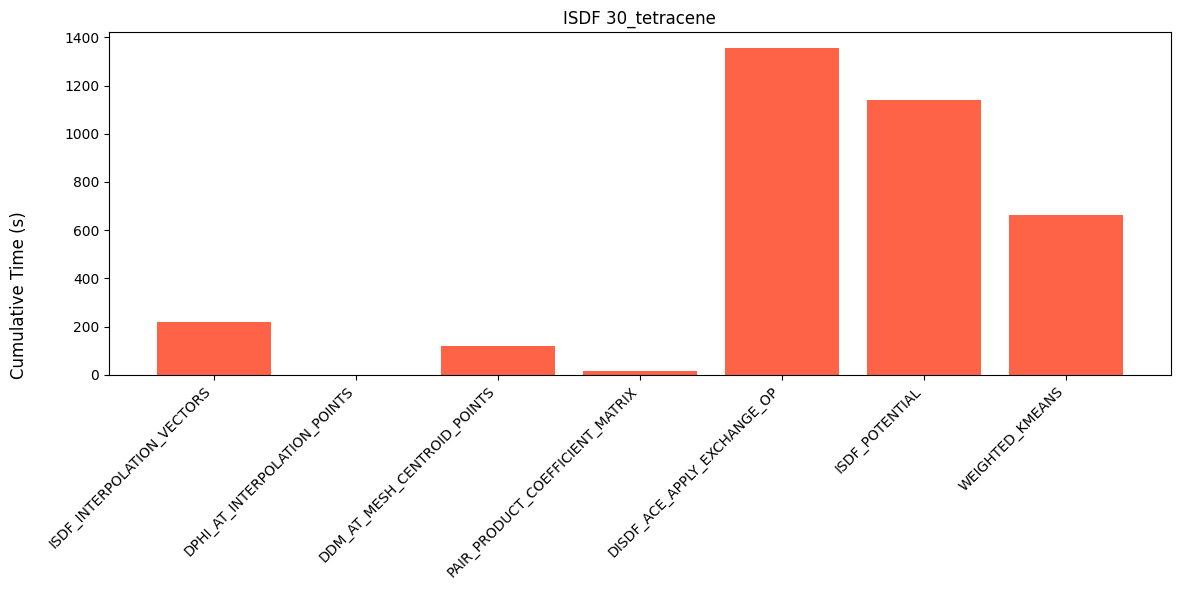

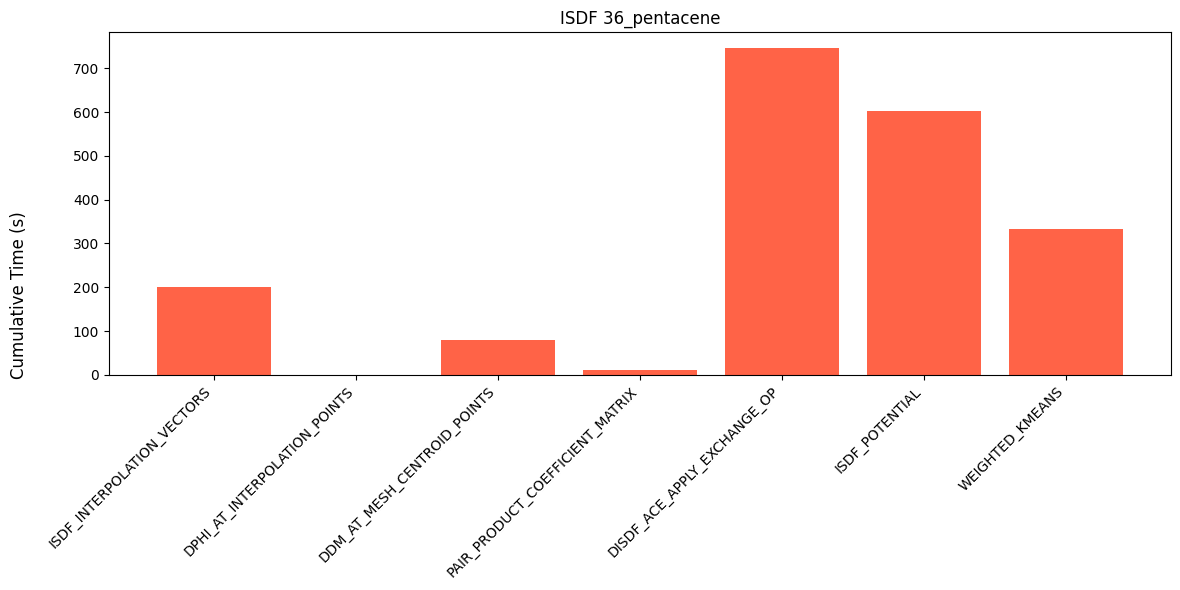

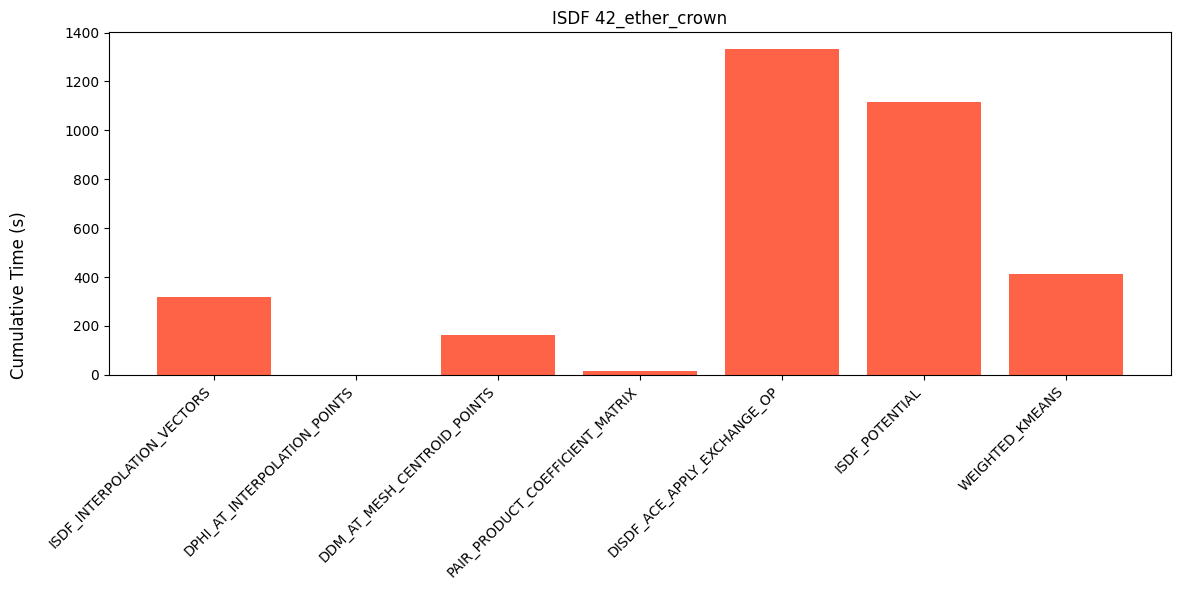

In [8]:
import matplotlib.pyplot as plt

# Functions
def add_bars(ax, labels, values, *, label=None, color=None, width=0.8, rot=45):
    x = np.arange(len(labels))
    ax.bar(x, values, width=width, label=label, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rot, ha='right')
    if label:
        ax.legend()
    return ax

to_total_time = lambda t, routines: [t[name]['TOTAL_TIME'] for name in routines]
to_time_per_call = lambda t, routines: [t[name]['TIME_PER_CALL'] for name in routines]

# Extract times of relevant routines
isdf_routines = ['ISDF_INTERPOLATION_VECTORS',
            'DPHI_AT_INTERPOLATION_POINTS',
            'DDM_AT_MESH_CENTROID_POINTS',
            'PAIR_PRODUCT_COEFFICIENT_MATRIX',
            'DISDF_ACE_APPLY_EXCHANGE_OP',
            'ISDF_POTENTIAL',
            'WEIGHTED_KMEANS']

# Plotting.
for dir in directories:
    fig, ax_isdf = plt.subplots(1, 1, figsize=(12, 6), sharey=True)
    add_bars(ax_isdf, isdf_routines, to_total_time(isdf_results[dir]['cumulative'], isdf_routines), color='tomato')
    ax_isdf.set_title(f'ISDF {dir}')
    fig.supylabel('Cumulative Time (s)')
    fig.tight_layout()

In [30]:
""" Convergence in KMeans as a function of SCF Iteration
Parsing
"""
import numpy as np
import re
from typing import List


def parse_kmeans_iterations(path) -> List[int]:
    pat = re.compile(r'^Kmeans converged in\s+(\d+)\s+iterations\b',
                     re.IGNORECASE | re.MULTILINE)
    
    with open(path, "r", encoding="utf-8") as fid:
        text = fid.read()
    
    # All iteration counts as ints
    return np.array([int(n) for n in pat.findall(text)])


def parse_kmeans_set(root, directories) -> dict:
    iters = {}
    for dir in directories:
        iters[dir] = parse_kmeans_iterations(root / dir / "terminal.out")
    return iters


# Iterations
# TODO Change this directory to /home/bucchera/exchange_calcs/kmeans_ref once all jobs run
ref_iters = parse_kmeans_set(Path("/home/bucchera/exchange_calcs/mpi_isdf"),
                             ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"])

l2_iters = parse_kmeans_set(Path("/home/bucchera/exchange_calcs/kmeans_l2"),
                                ["anthracene"])

#l2+ linlin criterion

#l2 + inertia

In [48]:
""" Parse final exact exchange energy
"""
from isdfbenchmarks.parser import static


def parse_exx(root, directories) -> dict:
    """ Parse the final exact exchange energy from a calculation
    :param root: 
    :param directories: 
    :return: 
    """
    exx = {}
    for dir in directories:
        exx[dir] = static.info_file(root / dir)['Energy']['Exchange']
    return exx

# Converged exact exchange energies, per molecule
ref_ace_root = Path("/home/bucchera/exchange_calcs/ace_references")
ref_ace_exx = parse_exx(ref_ace_root, ["anthracene", "tetracene", "pentacene", "ether_crown"])
#l2+ linlin criterion
#l2 + inertia

# ISDF exact exchange energies
# TODO Change the root dir for ref
ref_exx = parse_exx(Path("/home/bucchera/exchange_calcs/mpi_isdf"), 
                    ["24_anthracene",  "30_tetracene",  "36_pentacene",  "42_ether_crown"])

l2_exx = parse_exx(Path("/home/bucchera/exchange_calcs/kmeans_l2"), 
                    ["anthracene"])



In [53]:
""" Parse convergence in exact exchange energy
"""
from isdfbenchmarks.parser.stdout import parse_exchange_energy


def parse_exx_convergence(root: Path, directories: list) -> dict:
    exx_convergence = {}
    for dir in directories:
        with open(root / dir / "terminal.out", "r", encoding="utf-8") as fid:
            text = fid.read()
        exx_convergence[dir] = np.array([e for e in parse_exchange_energy(text).values()])
    return exx_convergence

# TODO Change this Path
ref_exx_convergence = parse_exx_convergence(Path("/home/bucchera/exchange_calcs/mpi_isdf"),
                             ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"])

l2_exx_convergence = parse_exx_convergence(Path("/home/bucchera/exchange_calcs/kmeans_l2"),
                                           ["anthracene"])

#l2+ linlin criterion

#l2 + inertia

In [63]:
""" Plot:
* Convergence in KMeans as a function of SCF Iteration
* Convergence in EXX as a function of SCF Iteration
"""
import matplotlib.pyplot as plt

# Combined in the next cell
plot_me = False

if plot_me:

    n_atoms = {"anthracene": '24', "tetracene": '30', "pentacene": '36', "ether_crown": '42'}
    
    # Convergence in KMeans as a function of SCF Iteration
    for molecule in ["anthracene"]:
        label = n_atoms[molecule] + '_' + molecule
        plt.plot(np.arange(len(ref_iters[label]), dtype=int), ref_iters[label], 'ro--', linewidth=2, markersize=8, label='Ref')
        plt.plot(np.arange(len(l2_iters[molecule]), dtype=int), l2_iters[molecule], 'bo--', linewidth=2, markersize=8, label='L2 Norm')
        plt.xlabel("SCF Iteration")
        plt.ylabel("Number of Kmeans Iterations")
        plt.title(molecule)
        plt.legend()
        plt.show()
    
    
    # Also show convergence in the total energy
    for molecule in ["anthracene"]:
        label = n_atoms[molecule] + '_' + molecule
        plt.plot(np.arange(len(ref_exx_convergence[label]), dtype=int), ref_exx_convergence[label], 
                 'ro--', linewidth=2, markersize=8, label='Ref')
        plt.plot(np.arange(len(l2_exx_convergence[molecule]), dtype=int), l2_exx_convergence[molecule], 
                 'bo--', linewidth=2, markersize=8, label='L2 Norm')
        plt.xlabel("SCF Iteration")
        plt.ylabel("Exact Exchange Energy (Ha)")
        plt.title(molecule)
        plt.legend()
        plt.show()



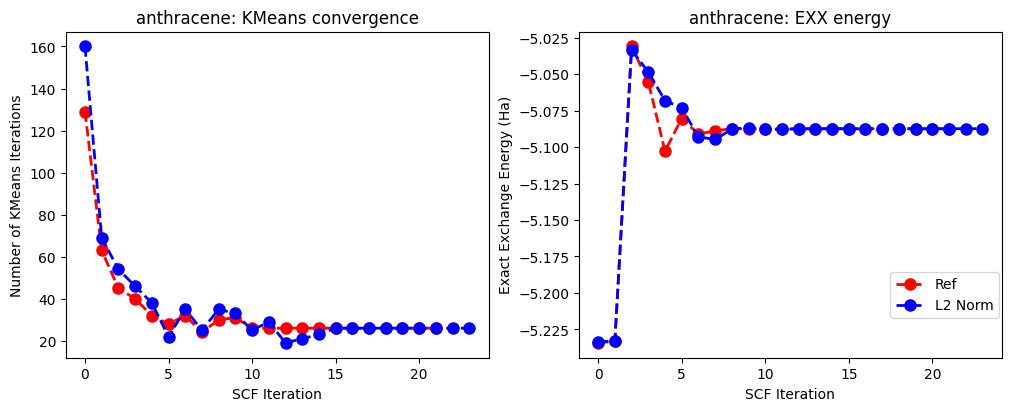

In [62]:
"""Same as the above, but combined into (n_molecules, 2) subplot
"""
import numpy as np
import matplotlib.pyplot as plt


n_atoms = {"anthracene": '24', "tetracene": '30', "pentacene": '36', "ether_crown": '42'}

molecules = ["anthracene"]

fig, axes = plt.subplots(
    nrows=len(molecules), ncols=2, figsize=(10, 4 * len(molecules)), 
    sharex='col', constrained_layout=True
)

# If there's only one molecule, axes comes back as a 1D array; normalize to 2D
if len(molecules) == 1:
    axes = np.array([axes])

for i, molecule in enumerate(molecules):
    label = f"{n_atoms[molecule]}_{molecule}"
    ax_left, ax_right = axes[i, 0], axes[i, 1]

    # --- Left: KMeans iterations vs SCF iteration ---
    x_ref = np.arange(len(ref_iters[label]), dtype=int)
    x_l2  = np.arange(len(l2_iters[molecule]), dtype=int)
    ax_left.plot(x_ref, ref_iters[label], 'ro--', linewidth=2, markersize=8, label='Ref')
    ax_left.plot(x_l2,  l2_iters[molecule],  'bo--', linewidth=2, markersize=8, label='L2 Norm')
    ax_left.set_xlabel("SCF Iteration")
    ax_left.set_ylabel("Number of KMeans Iterations")
    ax_left.set_title(f"{molecule}: KMeans convergence")

    # --- Right: Exact exchange energy vs SCF iteration ---
    x_ref_e = np.arange(len(ref_exx_convergence[label]), dtype=int)
    x_l2_e  = np.arange(len(l2_exx_convergence[molecule]), dtype=int)
    ax_right.plot(x_ref_e, ref_exx_convergence[label], 'ro--', linewidth=2, markersize=8, label='Ref')
    ax_right.plot(x_l2_e,  l2_exx_convergence[molecule],  'bo--', linewidth=2, markersize=8, label='L2 Norm')
    ax_right.set_xlabel("SCF Iteration")
    ax_right.set_ylabel("Exact Exchange Energy (Ha)")
    ax_right.set_title(f"{molecule}: EXX energy")

# Single shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.00, 0.20), ncol=1, frameon=True)

plt.show()


### Discussion

One currently cannot comment on the effect of the L2 norm on the number of kmeans iterations required to converge,
becasue the reference data uses a different grid spacing and number if interpolation points. However, it is clear that from the initial plot that the convergence is smoother using this criterion


Errors for anthracene [8.961e-05 2.519e-05]


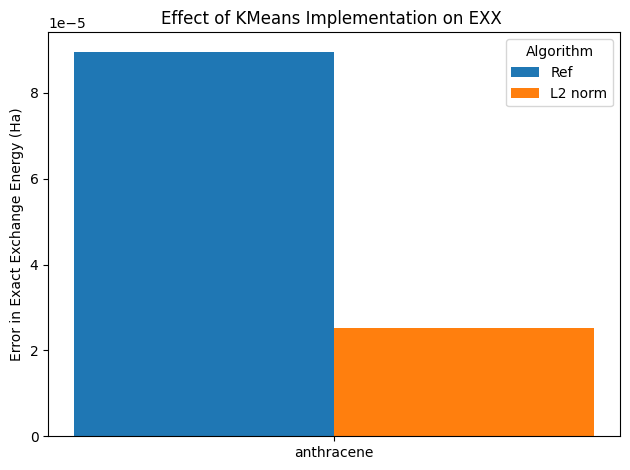

In [50]:
""" Plot Error in EXX for each KMeans implementation
"""
n_atoms = {"anthracene": '24', "tetracene": '30', "pentacene": '36', "ether_crown": '42'}

# Convert exx to relative errors w.r.t. ACE benchmark
delta_exx = {}

# TODO Extend to all molecules once they are computed
for molecule in ["anthracene"]:
    # TODO Label will go away once the reference is recompuited
    label = n_atoms[molecule] + '_' + molecule
    delta_exx[molecule] = np.array([np.abs(ref_exx[label] - ref_ace_exx[molecule]), # Ref
                                    l2_exx[molecule] - ref_ace_exx[molecule]]   # L2 norm
                                   ) 
    print(f"Errors for {molecule}", delta_exx[molecule])

# Bar plot setup
labels = list(delta_exx.keys()) 
vals = np.vstack([delta_exx[k] for k in labels])
n_groups, n_bars = vals.shape

x = np.arange(n_groups)                         # group positions
group_width = 0.8                               # total width occupied by each group
bar_width = group_width / n_bars

# center the block of bars on each group tick
offsets = (np.arange(n_bars) - (n_bars - 1) / 2) * bar_width

# TODO Extend as I compute more changes
kmeans_algo = ['Ref', 'L2 norm']
for i in range(n_bars):
    plt.bar(x + offsets[i], vals[:, i], width=bar_width, label=f'{kmeans_algo[i]}')

plt.xticks(x, labels, rotation=0)
plt.ylabel('Error in Exact Exchange Energy (Ha)')
plt.title('Effect of KMeans Implementation on EXX ')
plt.legend(title='Algorithm')
plt.tight_layout()
